**Foreword**\
Love for cricket is something I've recently developed. Moneyball is probably an inspiration for me, as it is for every sports data analyst. That and my passion for cricket has enabled me to make this report. The following is a proto-analysis on bowlers in IPL 2022 with limited data I've gathered. 

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns', 50)
import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [19]:
df = pd.read_excel('Total_stats.xlsx').drop(columns=['Unnamed: 0'],axis=1)
df.head()

,Player,Team,Hand,Type,Country,I,O,Balls,R,Extras,W,Econ,Avg,SR,4s,6s,Dots
0,A Badoni,LSG,R,Offbreak,India,2,2.0,12,11,0,2,5.50,5.50,6.00,0,0,3
1,A Nortje,DC,R,Fast,South Africa,6,22.2,134,217,9,9,9.72,24.11,14.89,21,10,47
2,Abdul Samad,SRH,R,Legbreak,India,1,1.0,6,8,0,0,8.00,0.00,0.00,1,0,1
3,Abhishek Sharma,SRH,L,Offbreak,India,3,4.0,24,38,0,0,9.50,0.00,0.00,2,2,3
4,AD Russell,KKR,R,Medium Fast,West Indies,13,28.1,169,278,11,17,9.87,16.35,9.94,27,12,57


In [20]:
df.isnull().sum()

Player     0
Team       0
Hand       0
Type       0
Country    0
I          0
O          0
Balls      0
R          0
Extras     0
W          0
Econ       0
Avg        0
SR         0
4s         0
6s         0
Dots       0
dtype: int64

**Filtering out pie-rollers**

I've noticed that there are many part-timers who shouldn't be taken into a serious analysis. So I'm planning on removing them out by using two measures, `Overs bowled per innings` and `Innings played`. This way, I can encapsulate all the out and out bowlers who played only towards the end like Sandeep Sharma, or players who were dropped mid-way like Pat Cummins, or consistent part-timers like Andre Russell or Liam Livingstone, who were almost useful sixth bowlers.

In [21]:
df['O/I'] = round(df['O']/df['I'],3)
df['W/I'] = round(df['W']/df['I'],3)

Let's create a new dataframe `updated_df`.The conditions I'm planning to give in are that are that the player should have played in more than 2 innings, and should've bowled more than 1.5 overs per innings. This removes the pie-rollers like Shreyas Iyer and Yashasvi Jaiswal.

In [22]:
updated_df = df[(df['I']>2) & (df['O/I']>1.5)]

In [23]:
updated_df['Player'].count()

83

83 players, who are going to be analyzed.

In [24]:
df[(df['I']<=2) & (df['O/I']<=1.5)][['Player']].head()

,Player
0,A Badoni
2,Abdul Samad
9,Aman Hakim Khan
20,D Brevis
25,DJ Mitchell


(In the above dataframe, we have shown players who aren't really useful to the analysis.)

----

**Understanding the columns for in-depth analysis**

- `I` - Number of innings the player has bowled in.

- `O` - Number of overs the players has bowled over the season. In the base of 6.

- `Balls` - Number of total balls the player has bowled over the season.

- `Runs` -  Total runs conceded by the bowler, including extras.

- `Extras` - Runs that have been conceded by the bowlers by bowling no-balls and wides (Not inclusive of byes and leg-byes as per ICC rules)

- `W` - Wickets taken by the bowler.

- `Econ` - Economy rate of a bowler, in terms of average runs conceded per over.

- `Avg` - Average runs conceded per wicket taken

- `SR` - Average balls taken per wicket taken

- `4s` - Number of fours conceded.

- `6s` - Number of sixes conceded.

- `Dots` - Number of balls that have resulted in a no-run delivery by the bowler.

- `O/I ratio` - Ratio of overs bowled to innings played, to identify main bowlers.

- `W/I ratio` - Ratio of wickets taken to innings played, to identify strike bowlers.

- `Dot %` - Number of dots faced divided by total balls bowled in terms of percentage.

- `Bound%` - Number of 4s and 6s divided by total balls bowled by the bowler in terms of percentage. 

- `ESRA` - Index to combine all of the Economy, Bowling Average and Bowling Strike Rate into one feature.

*Since it is better if all of them are low, I've tried not to divide any of them with the other. Instead, I've taken the square root of the sum of `Avg + SR` to bring it more in line with Economy, so that the defensive bowlers (Bowlers who's strike rate and average are high while economy is low, since they bowl defensive lengths) are not affected a lot. This index tends to give more weightage to economy.*

 - `Bound/Dots_%` - Ratio of boundaries to the dots (i.e,) how much boundaries a bowler leaks for every dot ball, in terms of percentage.

 - `6/4_ratio` - Ratio of 6s to the 4s a bowler concedes, helpful in identifying if a bowler is a strike-bowler (Bowlers who are attacking and take wickets)

-----

**Creating those columns:**

`Dot %`

In [25]:
updated_df['Dot %'] = round((updated_df['Dots']/updated_df['Balls']),4)*100

updated_df.head()

,Player,Team,Hand,Type,Country,I,O,Balls,R,Extras,W,Econ,Avg,SR,4s,6s,Dots,O/I,W/I,Dot %
1,A Nortje,DC,R,Fast,South Africa,6,22.2,134,217,9,9,9.72,24.11,14.89,21,10,47,3.700,1.500,35.07
4,AD Russell,KKR,R,Medium Fast,West Indies,13,28.1,169,278,11,17,9.87,16.35,9.94,27,12,57,2.162,1.308,33.73
6,AJ Tye,LSG,R,Medium Fast,Australia,3,11.0,66,107,3,2,9.73,53.50,33.00,13,4,21,3.667,0.667,31.82
8,Akash Deep,RCB,R,Medium,India,5,18.5,113,205,6,5,10.88,41.00,22.60,15,14,39,3.700,1.000,34.51
10,AR Patel,DC,L,Offbreak,India,13,43.0,258,321,4,6,7.47,53.50,43.00,20,15,85,3.308,0.462,32.95


`Bound%` 

In [26]:
updated_df.insert(loc=19,column='Bound%',value=round(((updated_df['4s']+updated_df['6s'])/updated_df['Balls'])*100,2))

`ESRA` 

In [27]:
updated_df.insert(loc=14,column='ESRA',value=round((np.sqrt(updated_df['SR'] + updated_df['Avg']) + updated_df['Econ']),3))

 
`Bound/Dots_%` 

In [28]:
updated_df['Bound/Dots_%'] = round(((updated_df['4s']+updated_df['6s'])/updated_df['Dots'])*100,2)

 
`6/4_ratio` 

In [29]:
updated_df.insert(loc=20,column='6/4_ratio',value=round((updated_df['6s']/updated_df['4s']),2))

Now we'll use the updated_df for further analysis.

In [30]:
updated_df.head()

,Player,Team,Hand,Type,Country,I,O,Balls,R,Extras,W,Econ,Avg,SR,ESRA,4s,6s,Dots,O/I,W/I,6/4_ratio,Bound%,Dot %,Bound/Dots_%
1,A Nortje,DC,R,Fast,South Africa,6,22.2,134,217,9,9,9.72,24.11,14.89,15.965,21,10,47,3.700,1.500,0.48,23.13,35.07,65.96
4,AD Russell,KKR,R,Medium Fast,West Indies,13,28.1,169,278,11,17,9.87,16.35,9.94,14.997,27,12,57,2.162,1.308,0.44,23.08,33.73,68.42
6,AJ Tye,LSG,R,Medium Fast,Australia,3,11.0,66,107,3,2,9.73,53.50,33.00,19.031,13,4,21,3.667,0.667,0.31,25.76,31.82,80.95
8,Akash Deep,RCB,R,Medium,India,5,18.5,113,205,6,5,10.88,41.00,22.60,18.855,15,14,39,3.700,1.000,0.93,25.66,34.51,74.36
10,AR Patel,DC,L,Offbreak,India,13,43.0,258,321,4,6,7.47,53.50,43.00,17.293,20,15,85,3.308,0.462,0.75,13.57,32.95,41.18


**Building a correlation chart**

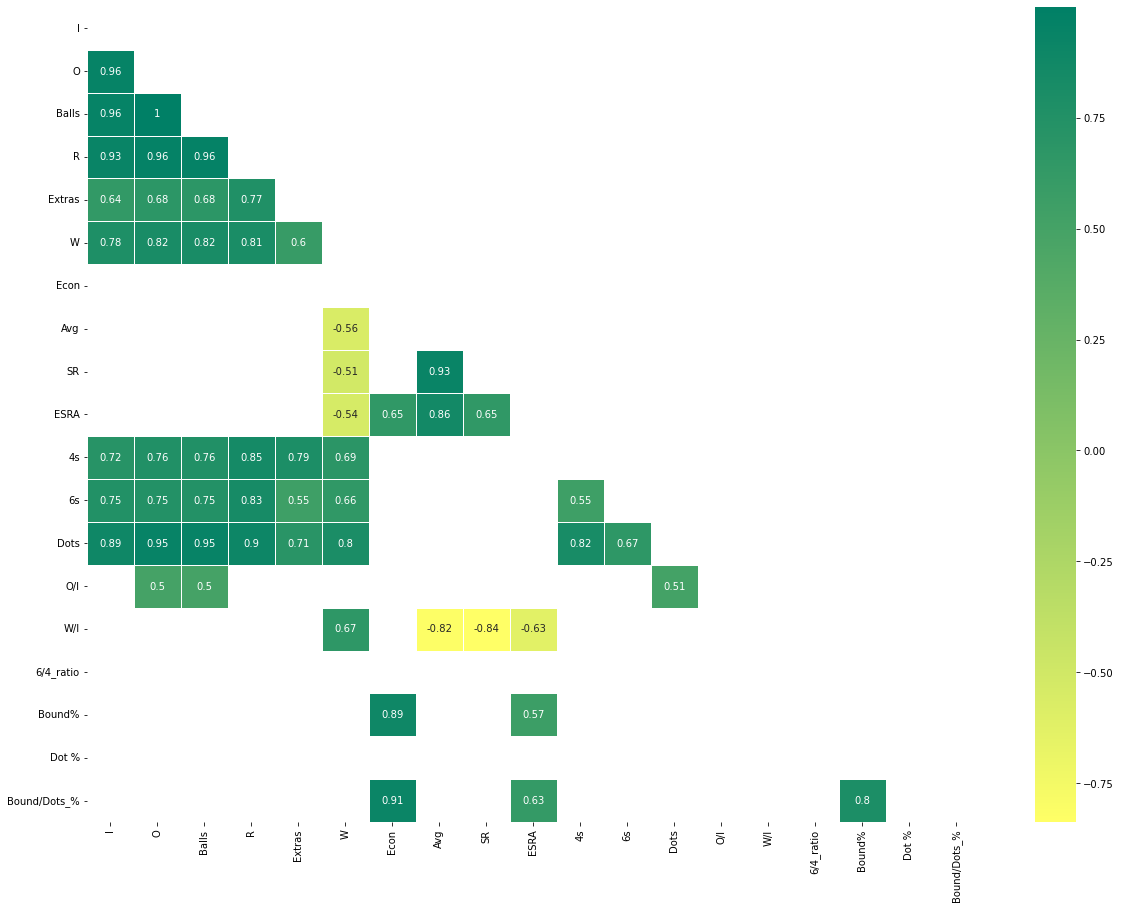

In [31]:
plt.figure(figsize=(20,15))
sns.heatmap(updated_df.corr()[(abs(updated_df.corr())>0.5) & (updated_df.corr()!= 1)],
            annot=True,cmap='summer_r',linewidths=0.5,mask = np.triu(np.ones_like(updated_df.corr())) )
plt.show()


We can see there are a lot of correlation between the variables, since they are really derived off the 4 basic stats - Innings, Overs, Wickets and Runs conceded.

**Analysing the dexterity of bowlers**

In [32]:
tt= pd.crosstab(columns = updated_df['Hand'], index = updated_df['Type'])

In [33]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,specs=[[{'type':'Domain'},{'type':'xy'}]])

fig.add_trace(go.Pie(labels=updated_df['Hand'].value_counts().index,
                     values=updated_df['Hand'].value_counts().values,
                     marker_colors=['#00CC96','gold']),row=1, col=1)

fig.add_trace(go.Bar(name='Left-Armers', x=tt.index, y=tt['L'],text=tt['L'],marker_color='gold'),row=1, col=2)
fig.add_trace(go.Bar(name='Right-Armers', x=tt.index, y=tt['R'],text=tt['R']),row=1, col=2)



fig.update_layout(height=400, width=980, title_text="Count of bowlers according to their dexterity")
fig.show()
pd.crosstab(columns = updated_df['Hand'], index = updated_df['Type'],margins=True,margins_name='Total')

Hand,L,R,Total
Type,,,
Fast,2,14,16
Legbreak,1,5,6
Legbreak Googly,1,4,5
Medium,7,12,19
Medium Fast,8,13,21
Offbreak,8,8,16
Total,27,56,83


Here, we see the total constitution of the types of bowlers and their handedness. 

32.5 % of the bowlers are left handed, which is definitely an indication that T20 is moving towards out-strategizing, since left-armers give that edge to the teams. The angle from which they bowl is difficult for the batters to face since there aren't a lot of leftie bowlers to begin with at the grassroots level.

In [34]:
print('Indian bowler constituency')
pd.crosstab(columns = updated_df[updated_df['Country'] == 'India']['Hand'],
            index = updated_df[updated_df['Country'] == 'India']['Type'],
            margins = True,
            margins_name='Total')

Indian bowler constituency


Hand,L,R,Total
Type,,,
Fast,1,6,7
Legbreak,1,3,4
Legbreak Googly,1,2,3
Medium,4,7,11
Medium Fast,4,7,11
Offbreak,7,5,12
Total,18,30,48


India seems to be doing really well in the lefties department, 37.5% of the total bowlers are left-armers, compared to the overall percentage of 32.5 %. 

In [35]:
round(updated_df.groupby('Hand')[[ 'Econ', 'Avg', 'SR', 'ESRA', '4s', '6s', 'Dots', 'O/I',
       'W/I', '6/4_ratio', 'Bound%', 'Dot %', 'Bound/Dots_%']].mean().T,3)

Hand,L,R
Econ,8.227,8.593
Avg,33.395,32.032
SR,24.686,22.494
ESRA,15.662,15.837
4s,20.963,23.357
6s,10.000,12.696
Dots,65.222,77.393
O/I,3.499,3.381
W/I,1.030,1.032
6/4_ratio,0.537,0.659


Inferences:

- Batters strike at a higher rate while facing right-handed bowlers. However this could be because there are more right-handed bowlers


- Right-Handed bowlers seems to have a higher wicket taking rate and economy. This could mean that there are more strike bowlers that are right handed.


- Average ESRA index is lower for lefties, meaning they are better rounded.


- Surprisingly, southpaws seem to have a lower dot% and bound/dot_% than the right-armers. This is puzzling. 

-------------------------------------------------------------------------------------------------------------------------

**Analysing the types of bowlers**

In [36]:
comp_chart = round(updated_df.groupby('Type')[['Econ', 'Avg', 'SR', 'ESRA', '4s', '6s', 'O/I',
       'W/I', '6/4_ratio', 'Bound%', 'Dot %', 'Bound/Dots_%']].mean().T,6)

In [37]:
(comp_chart.style.highlight_max(axis=1,
                                props='background-color:#fa7066;').highlight_min(axis=1, 
                                props='background-color:#86fa86;'))

Type,Fast,Legbreak,Legbreak Googly,Medium,Medium Fast,Offbreak
Econ,9.051875,7.650000,7.554000,8.715263,8.714762,7.890625
Avg,31.513750,21.535000,33.414000,30.773684,33.525238,37.890000
SR,20.705000,16.990000,26.904000,21.327895,23.744762,28.413125
ESRA,16.173875,13.837667,15.195800,15.735895,16.151238,15.864312
4s,31.875000,21.500000,19.000000,18.631579,28.142857,12.187500
6s,12.750000,20.333333,13.000000,8.842105,12.047619,10.562500
O/I,3.531812,3.709000,3.710200,3.456842,3.478524,2.987500
W/I,1.122625,1.350500,0.940000,1.154263,1.010905,0.728375
6/4_ratio,0.476875,0.951667,0.766000,0.476316,0.470476,0.956875
Bound%,21.684375,13.728333,14.208000,19.044211,19.731905,14.826875


I've just taken the average of %ratios of the bowlers, since I consider it to be a ratio and average would be a better indicator of central tendency, than just grouping by bowlers and taking total average.

**Inferences from the above table:**

- Pace bowlers are often taken to the cleaners, seeing that their `Econ` is at *~8.88*, with a high `boundary %`. Meanwhile against spinners, batters strike at just *~7.75* per over on an average. This shouldn't come as a surprise as pacers perform the thankless task of bowling at the powerplay and the death.


- Legbreak bowlers, having the likes of Rashid Khan and Hasaranga de Silva, are the most economical and best wicket takers of the lot.


- Mystery bowlers(Legbreak googly) are the second most economical bowlers and have the least `bound%` and `bound/dots_%`, understandably so, with their variations. I bet Sunil Narine alone has brought this value down with his exceptional defence.


- `ESRA index` for the leg-spinners is the least, meaning they are well rounded and more important to the team than other types of bowlers. Also they average a high number of wickets taken, meaning that they usually are the strike bowlers of the team.


- `Bound/Dots_%` of medium bowlers are the most, meaning that *115 - 125 kph* bowling dibbly-dobblers are punished for their bad balls more often than not. Harshal Patel really stands out from this lot, having just *35* `bound/dots_%` value.


- `6/4 ratio` is the high amongst all spinners, meaning it is easier to slog *90 kph* balls into the stands if they connect, than driving it to the rope, since there is barely any pace on the ball.


- Offbreak bowlers are probably there to contain batters, seeing that the `average` and `strike-rate` is the highest for them, while average wickets taken column is the lowest.


**ESRA index vs Bound/Dots_% :**


Conditions for being a strike bowler : `An ESRA index` lower than 15.5, and `W/I` above 1.2 . An ESRA index lesser than 15.5 ensures that overtly expensive bowlers like Cummins or Nortje don't come into the cluster, while W/I greater than 1.2 would be helpful with how active the bowlers were, with respect to taking wickets.

In [38]:
ESRAvsBound_Dots = px.scatter(data_frame=updated_df,x='ESRA',y='W/I',
           hover_name='Player',color='Type',symbol='Type',
           symbol_sequence= ['star-triangle-up', 'circle', 'diamond-tall', 'square','star','diamond'],
                              labels={'ESRA':'ESRA (lower the better)','W/I':'Wickets per Innings (higher the better)'},
                              title='ESRA-index vs W/I')
ESRAvsBound_Dots.add_shape(type='circle',x0=12,x1=15.5,y0=1.15,y1=2.2,fillcolor='lightyellow',opacity=0.5,layer='below')
ESRAvsBound_Dots.show()
strike_bowlers = updated_df[(updated_df['ESRA']<15.5)&(updated_df['W/I']>1)&(updated_df['I']>5)].sort_values('W/I',ascending=False)[['Player','Type','W/I','ESRA']]
strike_bowlers.head()

,Player,Type,W/I,ESRA
44,K Rabada,Fast,1.769,13.953
41,JR Hazlewood,Medium Fast,1.667,13.837
82,PWH de Silva,Legbreak,1.625,12.989
23,DJ Bravo,Medium,1.600,14.329
48,KK Ahmed,Medium,1.600,13.903


In [39]:
updated_df[(updated_df['ESRA']<15.5)&(updated_df['W/I']>1)&(updated_df['I']>5)].sort_values('W/I',ascending=False)[['Player','Type','W/I','ESRA']]['Type'].value_counts()

Fast               6
Legbreak           6
Medium             5
Medium Fast        4
Legbreak Googly    1
Name: Type, dtype: int64

Inferences:
- No surprises withstanding, again, leg-break bowlers dominate the cluster. Chahal, Hasaranga, Rabada, Hazlewood, Mohsin Khan and McCoy seem to have really had a stellar IPL. Props to Obed McCoy for arriving only in the second half of the IPL and becoming a key part of Rajasthan's death bowling unit. Talking about McCoy, slowerball specialists like McCoy, Bravo, Harshal Patel, Russell are appearing in this cluster, especially being death bowlers. Seems like slow balls is a valid tactic.


- Medium fast and off-break bowlers aren't really successful in getting the wickets of the batsmen.

**Economy vs Bound/Dots_%**

The box shows us the cluster of players who would be great additions as defensive bowlers to a playing XI. 

In [40]:
E_BDpercent = px.scatter(data_frame=updated_df,x='Econ',y='Bound/Dots_%',
           hover_name='Player',color='Type',symbol='Type',
           symbol_sequence= ['star-triangle-up', 'circle', 'diamond-tall', 'square','star','diamond'],
                        title='Economy vs Bound/Dot%')
E_BDpercent.add_shape(type='rect',x0=6.05,x1=7.98,y0=20.5,y1=53,fillcolor='lightyellow',opacity=0.5,layer='below' )

(Sunil Narine is missing because of my inability to create a slant ellipse, much to my frustration.)

**Quadrant analysis of bowlers and deciphering their types**

A quadrant analysis of bowlers based on economy rate and strike rate would help understanding the characteristics of individual bowlers.

In [41]:
fg = px.scatter(data_frame=updated_df,x='SR',y='Econ',
                labels={'SR':'Strike Rate (lower the better)','Econ':'Economy (lower the better)'},
                hover_name='Player',color='Type',symbol='Type',
                symbol_sequence=['star-triangle-up', 'circle', 'diamond-tall', 'square','star','diamond'])
fg.add_vline(x=20, line_color="black",opacity=0.5)
fg.add_hline(y=8,line_color="black",opacity=0.5)
# fg.add_shape(type='rect',x0=10.01,x1=19.9,y0=8.01, y1=9.99, line_width=0, fillcolor="white", opacity=0.6,name='Servicable bowlers')
fg.add_shape(y0= 6,y1=8,x0=10,x1=20, line_width=0, fillcolor="#86fa86",layer='below',opacity=0.3)
fg.add_shape(y0= 8,y1=10,x0=10,x1=20, line_width=0, fillcolor="#ffd966",layer='below', opacity=0.3)
fg.add_shape(y0= 6,y1=8,x0=20,x1=30, line_width=0, fillcolor="#6fa8dc",layer='below', opacity=0.3)
fg.add_shape(y0= 8,y1=10,x0=20,x1=30, line_width=0, fillcolor="#fa7066",layer='below', opacity=0.3)

- The green quadrant consists of bowlers who are very good at being both economical and taking wickets. Let's call them `Jacks` as a reference to the 'Jack of all trades' adage.


- The blue quadrant consists of bowlers who we will call as `Defensive-bowlers` or `Defenders` , since their economy rate is < 8 , while their strike rate is > 20, meaning wickets just don't come easily to them.


- The yellow quadrant consists of the third bowlers, who are expensive, but still take wickets at regular intervals. They aren't their sides MVPs, but are still good enough to be a part of the bowling unit. Shardul Thakur being a part of this quadrant is personally funny, since he was the epitome of this kind of bowling during his CSK days.`Attackers` is a good name(?)


- The red quadrant is for the bowlers who had nothing going for them this IPL. Players like Shabhaz Ahmed, Siraj, Varun, Jordan and Jansen are part of this quadrant. You shouldn't be looking upto these bowlers to make a difference in a game. While bowlers like Prasidh and Boult end up in this cluster, note that they are closer to the centre of the diagram.

**A closer look at the quadrants :**

In [42]:
fg = px.scatter(data_frame=updated_df,x='SR',y='Econ',
                labels={'SR':'Strike Rate (lower the better)','Econ':'Economy (lower the better)'},
                hover_name='Player',color='Type',symbol='Type',
                symbol_sequence=['star-triangle-up', 'circle', 'diamond-tall', 'square','star','diamond'])
fg.add_vline(x=20, line_color="black",opacity=0.4)
fg.add_hline(y=8,line_color="black",opacity=0.4)
# fg.add_shape(type='rect',x0=10.01,x1=19.9,y0=8.01, y1=9.99, line_width=0, fillcolor="white", opacity=0.6,name='Servicable bowlers')
fg.add_shape(y0= 6,y1=8,x0=10,x1=20, line_width=0, fillcolor="#86fa86",layer='below',opacity=0.1)
fg.add_shape(y0= 8,y1=10,x0=10,x1=20, line_width=0, fillcolor="#ffd966",layer='below', opacity=0.1)
fg.add_shape(y0= 6,y1=8,x0=20,x1=30, line_width=0, fillcolor="#6fa8dc",layer='below', opacity=0.1)
fg.add_shape(y0= 8,y1=10,x0=20,x1=30, line_width=0, fillcolor="#fa7066",layer='below', opacity=0.1)
fg.update_xaxes(range=[10,30])
fg.update_yaxes(range=[6,10])


- The leg-break bowlers seem to be dominating the `Jacks` quadrant. Only Kuldeep Yadav is missing from this. Other notable inclusions are Harshal Patel, Mohammad Shami, Umesh Yadav, Tim Southee, who was in and out of the team in place of Cummins, before KKR finally deciding to keep him. CSK spin duo Maheesh Theekshana and Moeen Ali too find their places here, owing to the management clearly delineating their roles I guess.


- Off break bowlers seem to be plenty in the `Defenders` cabinet, with Sunil Narine being the minister. Bhuvaneshwar Kumar, Arshdeep Singh and Simarjeet Singh are part of this quadrant as well, I guess due to them relying mainly on their line and length.


- In the `Attackers` quadrant, we can see a lot of medium and medium fast bowlers. Mukesh Choudhary, Umran Malik, Daniel Sams, Kagiso Rabada are part of this quadrant. Daniel Sams has done a lot of home-work to join this group after a pretty poor showing in the earlier part of the season.

--------

**Analysis based on teams**

In [43]:
teams_chart = round(updated_df.groupby('Team').mean(),3).T.drop(index=['O','W','Balls','Extras','R','Dots'])

In [44]:
(teams_chart.style.highlight_max(axis=1, 
                                props='background-color:#fa7066;').highlight_min(axis=1, 
                                props='background-color:#86fa86;'))

Team,CSK,DC,GT,KKR,LSG,MI,PBKS,RCB,RR,SRH
I,8.222000,8.889000,10.125000,10.000000,9.875000,6.727000,8.778000,11.375000,13.500000,8.250000
Econ,8.297000,8.394000,7.959000,8.546000,8.280000,8.792000,8.744000,8.412000,8.332000,8.838000
Avg,33.977000,30.031000,27.044000,31.816000,30.332000,29.701000,37.652000,42.322000,28.710000,32.658000
SR,24.436000,21.900000,20.291000,23.263000,21.534000,20.440000,26.577000,30.386000,20.987000,22.340000
ESRA,15.796000,15.504000,14.809000,15.806000,15.370000,15.726000,16.568000,16.600000,15.318000,16.149000
4s,18.111000,22.222000,25.125000,21.429000,28.000000,16.091000,20.667000,22.125000,36.167000,22.375000
6s,8.889000,11.222000,11.125000,13.429000,10.750000,9.545000,9.778000,18.000000,16.667000,11.750000
O/I,3.248000,3.423000,3.443000,3.596000,3.514000,3.266000,3.235000,3.215000,3.826000,3.656000
W/I,0.922000,1.070000,1.045000,1.088000,1.067000,1.100000,0.873000,0.912000,1.188000,1.094000
6/4_ratio,0.620000,0.514000,0.468000,0.696000,0.454000,0.683000,0.618000,0.906000,0.547000,0.670000


Inferences from the above table:

- Bowlers from Mumbai Indians have the lowest average innings played, meaning there was a chopping and changing to set up their bowling attack, while Rajasthan Royals' bowlers have the highest average innings player, probably due to them sticking to the quartet of Boult, Prasidh, Ashwin and Chahal playing all the matches.


- Gujarat Titans have the lowest `Econ`, `Avg`, `SR`, `ESRA` meaning they had the best bowling attack of all the teams in the tournament. RR, who are the runners up, have the second lowest of all the measures.


- RCB have the worst `Avg`,`SR`, meaning they struggled with taking wickets at regular intervals. They also concede the most sixes in a match, on an average.


- SRH have a very high economy rate, understandably so due to having the likes of Marco Jansen and Umran Malik, who went for a lot of runs.

In [45]:
teams = teams_chart.T
teams['Team'] = teams.index

t_fig = px.scatter(data_frame=teams,x='SR',y='Econ',hover_name='Team',color='Team',size='ESRA',
                   labels={'SR':'Strike Rate (lower the better)','Econ':'Economy (lower the better)'},
        color_discrete_sequence=['#f2cd5e','#073763','#38761d','#674ea7','#a9f3da','#3d85c6','#cc0000','#000000','#ff71b3','#f5783c'])
t_fig.add_vline(x=22, line_color="black",opacity=0.4)
t_fig.add_hline(y=8.4,line_color="black",opacity=0.4)

I've displayed the quadrant lines very arbitrarily, just to make a point about the bowling quality of teams similar to the quadrant analysis of the bowlers. 

Here, we can see that RR, GT and LSG the teams who made it to play-offs had a very good bowling attack. RCB are an aberration, seeing that their strike rate is really poor, while their economy rate is not the greatest too. Meaning, despite possessing the HHH attack of Harshal, Hazlewood and Hasaranga, their attack was just weak.

------

**Powerplay Overs, Middle Overs and Death Overs analysis**

**Reading the necessary tables and feature engineering columns as per the analysed dataframe.**

In [46]:
Powerplay_table = pd.read_excel('Powerplay_table.xlsx').drop(columns=['Unnamed: 0'],axis=1)
Middle_Overs_table = pd.read_excel('Middle_Overs_table.xlsx').drop(columns=['Unnamed: 0'],axis=1)
Death_table = pd.read_excel('Death_table.xlsx').drop(columns=['Unnamed: 0'],axis=1)

Powerplay_table['O/I'] = round(Powerplay_table['O']/Powerplay_table['I'],2)
Powerplay_table['W/I'] = round(Powerplay_table['W']/Powerplay_table['I'],3)


Middle_Overs_table['O/I'] = round(Middle_Overs_table['O']/Middle_Overs_table['I'],2)
Middle_Overs_table['W/I'] = round(Middle_Overs_table['W']/Middle_Overs_table['I'],3)


Death_table['O/I'] = round(Death_table['O']/Death_table['I'],2)
Death_table['W/I'] = round(Death_table['W']/Death_table['I'],3)

In [47]:
Powerplay_table = Powerplay_table[(Powerplay_table['O/I']>= 1.2)&(Powerplay_table['I']>2)&(Powerplay_table['W/I']>0)&(Powerplay_table['O']>=10)]

Middle_Overs_table = Middle_Overs_table[(Middle_Overs_table['O/I']>= 1.5)&(Middle_Overs_table['I']>2)&(Middle_Overs_table['O']>=10)]

Death_table = Death_table[(Death_table['O/I']>= 1)&(Death_table['I']>2)&(Death_table['O']>=7)]

In [48]:
# `Dot %`

Powerplay_table['Dot %'] = round((Powerplay_table['Dots']/Powerplay_table['Balls']),4)*100
Middle_Overs_table['Dot %'] = round((Middle_Overs_table['Dots']/Middle_Overs_table['Balls']),4)*100
Death_table['Dot %'] = round((Death_table['Dots']/Death_table['Balls']),4)*100


# `Bound%` 

Powerplay_table.insert(loc=19,column='Bound%',value=round(((Powerplay_table['4s']+Powerplay_table['6s'])/Powerplay_table['Balls'])*100,2))
Middle_Overs_table.insert(loc=19,column='Bound%',value=round(((Middle_Overs_table['4s']+Middle_Overs_table['6s'])/Middle_Overs_table['Balls'])*100,2))
Death_table.insert(loc=19,column='Bound%',value=round(((Death_table['4s']+Death_table['6s'])/Death_table['Balls'])*100,2))

# `ESRA` 

Powerplay_table.insert(loc=14,column='ESRA',value=round((np.sqrt(Powerplay_table['SR'] + Powerplay_table['Avg']) + Powerplay_table['Econ']),3))
Middle_Overs_table.insert(loc=14,column='ESRA',value=round((np.sqrt(Middle_Overs_table['SR'] + Middle_Overs_table['Avg']) + Middle_Overs_table['Econ']),3))
Death_table.insert(loc=14,column='ESRA',value=round((np.sqrt(Death_table['SR'] + Death_table['Avg']) + Death_table['Econ']),3))


# `Bound/Dots_%` 

Powerplay_table['Bound/Dots_%'] = round(((Powerplay_table['4s']+Powerplay_table['6s'])/Powerplay_table['Dots'])*100,2)
Middle_Overs_table['Bound/Dots_%'] = round(((Middle_Overs_table['4s']+Middle_Overs_table['6s'])/Middle_Overs_table['Dots'])*100,2)
Death_table['Bound/Dots_%'] = round(((Death_table['4s']+Death_table['6s'])/Death_table['Dots'])*100,2)


# `6/4_ratio` 

Powerplay_table.insert(loc=20,column='6/4_ratio',value=round((Powerplay_table['6s']/Powerplay_table['4s']),2))
Middle_Overs_table.insert(loc=20,column='6/4_ratio',value=round((Middle_Overs_table['6s']/Middle_Overs_table['4s']),2))
Death_table.insert(loc=20,column='6/4_ratio',value=round((Death_table['6s']/Death_table['4s']),2))


# `Replacing infinity and null values`

Powerplay_table.replace({np.nan:0,np.inf:0},inplace=True)
Middle_Overs_table.replace({np.nan:0,np.inf:0},inplace=True)
Death_table.replace({np.nan:0,np.inf:0},inplace=True)

---------

T20 strategy has grown so much in the recent years, far from the 2008 season. A bowler is judged by how effective he is in his specified role. Here, in this section, I'm planning to analyze bowlers by phases of play, keep certain criteria for the roles he has to perform during these phases.

**Analysing Powerplay bowlers**

A fielding team always looks to take quick wickets of dangerous openers using the swinging ball during powerplays, when there are just two fielders outside the circle. My criteria is simple. Keep the runrate at less than 9, while taking wickets higher than 0.25

In [49]:
PP = Powerplay_table[Powerplay_table['W/I']>=0.25].sort_values(['ESRA','W/I'],ascending=[True,False]).head(7)

In [50]:
PP[['Player','Team','Type','W','Econ','Avg','SR','ESRA','W/I']]

,Player,Team,Type,W,Econ,Avg,SR,ESRA,W/I
66,Mohsin Khan,LSG,Fast,6,5.25,14.00,16.00,10.727,0.667
27,DR Sams,MI,Medium Fast,8,7.05,18.50,15.75,12.902,0.727
59,M Prasidh Krishna,RR,Fast,10,6.58,23.70,21.60,13.311,0.588
116,UT Yadav,KKR,Medium Fast,8,6.42,24.88,23.25,13.358,0.667
64,Mohammed Shami,GT,Fast,11,6.62,24.09,21.82,13.396,0.688
48,KK Ahmed,DC,Medium,4,6.11,27.50,27.00,13.492,0.400
41,JR Hazlewood,RCB,Medium Fast,7,6.84,24.43,21.43,13.612,0.583


Mohsin Khan seems to be the best bowler of the lot, having a really low economy, while also taking wickets at good intervals. Surprisingly, Daniel Sams makes the list.

Visualizing the best powerplay bowlers

In [51]:

fig = make_subplots(rows=1, cols=2,subplot_titles=['Wickets per Innings','Economy'])

fig.add_trace(go.Bar(name = 'W/I',x=PP['Player'], y=PP['W/I'],marker_color='indianred'),row=1, col=1)

fig.add_trace(go.Scatter(name='Economy',x=PP['Player'], y=PP['Econ'],marker_color='#4ab088'),row=1, col=2)#red
# fig.add_trace(go.Scatter(x=PP['Econ'], y=PP['ESRA']),row=2, col=1)

fig.update_layout(height=400, width=960)
fig.show()

In [52]:
Powerplay_table[Powerplay_table['W/I']<=0.5].sort_values(['Econ','W/I'],ascending=[False,True]).head(3)[['Player','Team','Type','W','Econ','Avg','SR','ESRA','W/I']]                   

,Player,Team,Type,W,Econ,Avg,SR,ESRA,W/I
65,Mohammed Siraj,RCB,Medium Fast,5,10.23,63.4,37.2,20.260,0.333
1,A Nortje,DC,Fast,3,9.30,31.0,20.0,16.441,0.500
107,SN Thakur,DC,Medium Fast,4,8.70,43.5,30.0,17.273,0.286


No surprises here, Siraj statistically has been the worst Powerplay bowler of IPL 2022, and he is in glorious company of Lord Thakur and Anrich Nortje (shame really, that hip injury has really taken the wind out of him).

**Analysing Middle Overs bowlers**

We are going to go with two different approcahes. One, to find bowlers who take wickets at the cost of runs, and vice-versa. Ideally a team would want both types of players to complement each other, with one increasing the pressure on the batting side with their measly economy rate, and the other utilizing the pressure to take wickets.

In [53]:
mo_strike = Middle_Overs_table.sort_values('W/I',ascending=False).head(7)
mo_strike

,Player,Team,Hand,Type,Nationality,I,O,Balls,R,Extras,W,Econ,Avg,SR,ESRA,4s,6s,Dots,O/I,W/I,6/4_ratio,Bound%,Dot %,Bound/Dots_%
51,Kuldeep Yadav,DC,L,Legbreak,India,14,47.4,286,397,5,20,8.33,19.85,14.30,14.174,27,21,91,3.39,1.429,0.78,16.78,31.82,52.75
115,Umran Malik,SRH,R,Fast,India,14,44.2,266,375,19,19,8.46,19.74,14.00,14.269,44,13,118,3.16,1.357,0.30,21.43,44.36,48.31
82,PWH de Silva,RCB,R,Legbreak,Sri Lanka,16,48.0,288,349,5,20,7.27,17.45,14.40,12.914,17,23,115,3.00,1.250,1.35,13.89,39.93,34.78
42,K Gowtham,LSG,R,Offbreak,India,4,10.0,60,77,0,5,7.70,15.40,12.00,12.935,2,7,26,2.50,1.250,3.50,15.00,43.33,34.62
124,YS Chahal,RR,R,Legbreak,India,17,53.0,318,394,14,20,7.43,19.70,15.90,13.397,21,17,100,3.12,1.176,0.81,11.95,31.45,38.00
93,Rashid Khan,GT,R,Legbreak,Afghanistan,16,51.5,311,322,7,17,6.21,18.94,18.29,12.312,10,12,103,3.22,1.062,1.20,7.07,33.12,21.36
36,J Suchith,SRH,L,Offbreak,India,5,14.0,84,96,5,5,6.86,19.20,16.80,12.860,5,5,38,2.80,1.000,1.00,11.90,45.24,26.32


Strike bowlers

In [54]:

fig = make_subplots(rows=1, cols=2,subplot_titles=['Wickets per Innings & Economy rate','Bound%'])

fig.add_trace(go.Bar(name='W/I x 10',x=mo_strike['Player'], y=mo_strike['W/I']*10,marker_color='#f2c64c'),row=1, col=1)

fig.add_trace(go.Scatter(name='Econ',x=mo_strike['Player'], y=mo_strike['Econ'],marker_color='#4c78f2'),row=1, col=1)#red
fig.add_trace(go.Scatter(name = 'Bound%',x=mo_strike['Player'], y=mo_strike['Bound%']),row=1, col=2)

fig.update_layout(height=400, width=960)
fig.show()
mo_strike[['Player','Team','Type','W/I','Econ','Avg','SR','ESRA']]

,Player,Team,Type,W/I,Econ,Avg,SR,ESRA
51,Kuldeep Yadav,DC,Legbreak,1.429,8.33,19.85,14.30,14.174
115,Umran Malik,SRH,Fast,1.357,8.46,19.74,14.00,14.269
82,PWH de Silva,RCB,Legbreak,1.250,7.27,17.45,14.40,12.914
42,K Gowtham,LSG,Offbreak,1.250,7.70,15.40,12.00,12.935
124,YS Chahal,RR,Legbreak,1.176,7.43,19.70,15.90,13.397
93,Rashid Khan,GT,Legbreak,1.062,6.21,18.94,18.29,12.312
36,J Suchith,SRH,Offbreak,1.000,6.86,19.20,16.80,12.860


So many legbreak bowlers! No wonder all the international teams are chasing after their own legspinners in white ball cricket, seeing how crucial they are in their wicket-taking ability. Umran Malik really is an aberration, since he is a fast bowler but has been exclusively used in the middle overs, bowling 3 overs per match, and taking wickets at regular intervals.

Economy bowlers

In [55]:
mo_econ = Middle_Overs_table.sort_values('Econ').head(7)
mo_econ

,Player,Team,Hand,Type,Nationality,I,O,Balls,R,Extras,W,Econ,Avg,SR,ESRA,4s,6s,Dots,O/I,W/I,6/4_ratio,Bound%,Dot %,Bound/Dots_%
108,SP Narine,KKR,R,Legbreak Googly,West Indies,14,43.0,258,228,3,8,5.30,28.50,32.25,13.094,5,10,109,3.07,0.571,2.00,5.81,42.25,13.76
93,Rashid Khan,GT,R,Legbreak,Afghanistan,16,51.5,311,322,7,17,6.21,18.94,18.29,12.312,10,12,103,3.22,1.062,1.20,7.07,33.12,21.36
47,KH Pandya,LSG,L,Offbreak,India,12,29.0,174,180,3,7,6.21,25.71,24.86,13.321,8,5,53,2.42,0.583,0.62,7.47,30.46,24.53
35,HV Patel,RCB,R,Medium,India,15,31.0,186,195,9,10,6.29,19.50,18.60,12.463,14,5,73,2.07,0.667,0.36,10.22,39.25,26.03
61,MJ Santner,CSK,L,Offbreak,New Zealand,6,12.0,72,80,0,4,6.67,20.00,18.00,12.834,3,3,22,2.00,0.667,1.00,8.33,30.56,27.27
36,J Suchith,SRH,L,Offbreak,India,5,14.0,84,96,5,5,6.86,19.20,16.80,12.860,5,5,38,2.80,1.000,1.00,11.90,45.24,26.32
63,MM Ali,CSK,R,Offbreak,England,10,21.5,131,151,3,8,6.92,18.88,16.38,12.858,6,9,47,2.15,0.800,1.50,11.45,35.88,31.91


In [56]:

fig = make_subplots(rows=1, cols=2,subplot_titles=['Wickets per Innings & Economy rate','Bound%'])

fig.add_trace(go.Bar(name='W/I x 10',x=mo_econ['Player'], y=mo_econ['W/I']*10,marker_color='#f2c64c'),row=1, col=1)

fig.add_trace(go.Scatter(name='Econ',x=mo_econ['Player'], y=mo_econ['Econ'],marker_color='#4c78f2'),row=1, col=1)#red
fig.add_trace(go.Scatter(name = 'Bound%',x=mo_econ['Player'], y=mo_econ['Bound%']),row=1, col=2)

fig.update_layout(height=400, width=960)
fig.show()
mo_econ[['Player','Team','Type','W/I','Econ','Dot %','Bound/Dots_%','ESRA']]

,Player,Team,Type,W/I,Econ,Dot %,Bound/Dots_%,ESRA
108,SP Narine,KKR,Legbreak Googly,0.571,5.30,42.25,13.76,13.094
93,Rashid Khan,GT,Legbreak,1.062,6.21,33.12,21.36,12.312
47,KH Pandya,LSG,Offbreak,0.583,6.21,30.46,24.53,13.321
35,HV Patel,RCB,Medium,0.667,6.29,39.25,26.03,12.463
61,MJ Santner,CSK,Offbreak,0.667,6.67,30.56,27.27,12.834
36,J Suchith,SRH,Offbreak,1.000,6.86,45.24,26.32,12.860
63,MM Ali,CSK,Offbreak,0.800,6.92,35.88,31.91,12.858


Sunil Narine is the man. He'll walk into my team, any day of the week, owing to that economy rate. That Boundary per Dot % is just too miserly, meaning he'll get hit for boundaries very rarely for every dotball he bowls. Rashid Khan is the other bowler who's worth his weight in gold, having both a low economy rate and a good wicket-taking ability. Harshal Patel makes the list, despite being an exclusive death bowler, probably coming on to pick a wicket or so if the going got tough for RCB.

**Death Over analysis**

The criteria is defense, defense, defense. Batters tend to go big in the final overs of the game, to maximize the score. Sometimes they do lose their wickets, but it is often a result of an unforced error.

In [57]:
do = Death_table.sort_values('Econ').head(7)

In [58]:
do

,Player,Team,Hand,Type,Nationality,I,O,Balls,R,Extras,W,Econ,Avg,SR,ESRA,4s,6s,Dots,O/I,W/I,6/4_ratio,Bound%,Dot %,Bound/Dots_%
39,JJ Bumrah,MI,R,Fast,India,14,17.2,104,128,3,7,7.38,18.29,14.86,13.138,10,3,33,1.23,0.500,0.30,12.50,31.73,39.39
11,Arshdeep Singh,PBKS,L,Medium Fast,India,14,17.0,102,129,2,4,7.59,32.25,25.50,15.189,11,1,21,1.21,0.286,0.09,11.76,20.59,57.14
76,OC McCoy,RR,L,Medium,West Indies,7,9.5,59,84,5,8,8.54,10.50,7.38,12.768,6,4,24,1.36,1.143,0.67,16.95,40.68,41.67
15,B Kumar,SRH,R,Medium Fast,India,14,19.1,115,165,10,9,8.61,18.33,12.78,14.188,14,5,38,1.36,0.643,0.36,16.52,33.04,50.00
122,Yash Dayal,GT,L,Medium Fast,India,9,9.0,54,80,7,3,8.89,26.67,18.00,15.574,5,2,16,1.00,0.333,0.40,12.96,29.63,43.75
23,DJ Bravo,CSK,R,Medium,West Indies,10,12.2,74,113,9,11,9.16,10.27,6.73,13.283,10,3,24,1.22,1.100,0.30,17.57,32.43,54.17
70,Mustafizur Rahman,DC,L,Medium,Bangladesh,8,15.0,90,142,3,6,9.47,23.67,15.00,15.689,12,6,26,1.88,0.750,0.50,20.00,28.89,69.23


In [59]:

fig = make_subplots(rows=1, cols=2,subplot_titles=['Strike-Rate','Economy'])

fig.add_trace(go.Bar(name = 'SR',x=do['Player'], y=do['SR'],marker_color='darkturquoise'),row=1, col=1)

fig.add_trace(go.Scatter(name='Econ',x=do['Player'], y=do['Econ'],marker_color='#4ab088'),row=1, col=2)

fig.update_layout(height=400, width=960)
fig.show()
do[['Player','Team','Type','Econ','ESRA']]

,Player,Team,Type,Econ,ESRA
39,JJ Bumrah,MI,Fast,7.38,13.138
11,Arshdeep Singh,PBKS,Medium Fast,7.59,15.189
76,OC McCoy,RR,Medium,8.54,12.768
15,B Kumar,SRH,Medium Fast,8.61,14.188
122,Yash Dayal,GT,Medium Fast,8.89,15.574
23,DJ Bravo,CSK,Medium,9.16,13.283
70,Mustafizur Rahman,DC,Medium,9.47,15.689


Despite being murmurs of him not being at his usual best, Bumrah tops the list at being a great defensive bowler at the death. That makes me dream of how good he'd be once he gets back to his best. Arshdeep Singh, comes second on this list, having a variety of skills in his repertoire like the slower ones, yorkers to his main ability - hitting the hard lengths. T20 Veteran DJ Bravo makes the list and shows that he still hasn't lost his mettle. 


**Choosing the bowlers for my team**

In [60]:
xc = list(Middle_Overs_table['Player']) + list(Death_table['Player'])

In [61]:
{i:xc.count(i) for i in xc if xc.count(i) >1}

{'D Pretorius': 2,
 'DJ Bravo': 2,
 'HV Patel': 2,
 'LH Ferguson': 2,
 'OC McCoy': 2,
 'T Natarajan': 2}

For Powerplay bowling, I'll Choose Mohsin Khan and Jasprit Bumrah, since he can be useful at the death too. My middle over bowlers would be Rashid Khan and Sunil Narine, with the former attacking and the latter defending. Now for our fifth bowler, I'll choose Harshal Patel, for 2 overs in the middle and 2 overs in the death.

In [62]:
Top5 = updated_df[updated_df['Player'].isin(['Mohsin Khan','JJ Bumrah','SP Narine','Rashid Khan','HV Patel'])]

In [63]:
Top5

,Player,Team,Hand,Type,Country,I,O,Balls,R,Extras,W,Econ,Avg,SR,ESRA,4s,6s,Dots,O/I,W/I,6/4_ratio,Bound%,Dot %,Bound/Dots_%
35,HV Patel,RCB,R,Medium,India,15,53.3,321,410,25,19,7.66,21.58,16.89,13.862,26,20,123,3.553,1.267,0.77,14.33,38.32,37.40
39,JJ Bumrah,MI,R,Fast,India,14,53.2,320,383,7,15,7.18,25.53,21.33,14.025,37,11,133,3.800,1.071,0.30,15.00,41.56,36.09
66,Mohsin Khan,LSG,L,Fast,India,9,33.0,198,197,12,14,5.97,14.07,14.14,11.281,18,5,105,3.667,1.556,0.28,11.62,53.03,21.90
93,Rashid Khan,GT,R,Legbreak,Afghanistan,16,63.5,383,421,7,19,6.60,22.16,20.16,13.105,16,16,123,3.969,1.188,1.00,8.36,32.11,26.02
108,SP Narine,KKR,R,Legbreak Googly,West Indies,14,56.0,336,312,7,9,5.57,34.67,37.33,14.055,11,12,138,4.000,0.643,1.09,6.85,41.07,16.67


In [64]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2,subplot_titles=['Strike-Rate','Economy','Overs','ESRA'])

fig.add_trace(go.Bar(name = 'SR',x=Top5['Player'], y=Top5['SR'],marker_color='#56a697'),row=1, col=1)

fig.add_trace(go.Scatter(name='Econ',x=Top5['Player'], y=Top5['Econ'],marker_color='#e19678'),row=1, col=2)
fig.add_trace(go.Scatter(name='Overs',x=Top5['Player'], y=Top5['O'],marker_color='#3a3e75'),row=2, col=1)
fig.add_trace(go.Scatter(name='ESRA',x=Top5['Player'], y=Top5['ESRA'],marker_color='#e65a97'),row=2, col=2)

fig.update_layout(height=700, width=960)
fig.show()
Top5[['Player','Team','Type','Econ','Avg','SR','W/I','Bound%','ESRA']]

,Player,Team,Type,Econ,Avg,SR,W/I,Bound%,ESRA
35,HV Patel,RCB,Medium,7.66,21.58,16.89,1.267,14.33,13.862
39,JJ Bumrah,MI,Fast,7.18,25.53,21.33,1.071,15.00,14.025
66,Mohsin Khan,LSG,Fast,5.97,14.07,14.14,1.556,11.62,11.281
93,Rashid Khan,GT,Legbreak,6.60,22.16,20.16,1.188,8.36,13.105
108,SP Narine,KKR,Legbreak Googly,5.57,34.67,37.33,0.643,6.85,14.055


So, that's about it. Thanks for taking the time to look at this analysis!

In [65]:
updated_df.to_excel('updated_dfcopy.xlsx')